# Lab 3: Classification (Part 2) and Model Selection

## Name: Punit K. Jha (punit2)

### Due September 18, 2019 11:59 PM

**Logistics and Lab Submission**

See the [course website](https://courses.engr.illinois.edu/ece365/fa2019/logisticsvvv.html). Remember that all labs count equally, despite the labs being graded from a different number of total points).

**What You Will Need To Know For This Lab**

This lab covers a few more basic classifiers which can be used for M-ary classification:
- Naive Bayes
- Logistic Regression
- Support Vector Machines

as well as cross-validation, a tool for model selection and assessment.
 
There are some problems which have short answer questions. <b>Do not write an essay -- a few (1-2) complete sentences will suffice.</b>

<b>Also, be clear about your answers</b>. For example, if a question asks you "Which classifier would you choose?", be unequivocal about which classifier you would choose (and why); as engineers, part of your job is to make design decisions and justify them in the context of the alternatives and in the application. 

Remember in many applications, the end goal is not always "run a classifier", like in a homework problem, but is to use the output of the classifier in the context of the problem at hand (e.g. detecting spam, identifying cancer, etc.). Because of this, some of our Engineering Design-type questions are designed to get you to think about the entire design problem at a high level.


**Warning: Do not train on your test sets. You will automatically have your score halved for a problem if you train on your test data.**

**Preamble (don't change this)**

In [2]:
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
from sklearn import model_selection
from numpy import genfromtxt
from sklearn.preprocessing import MinMaxScaler
import glob

Populating the interactive namespace from numpy and matplotlib


### Problem 1: Spam Detection (90 points)

In this problem, you will be constructing a crude spam detector. As you all know, when you receive an e-mail, it can be divided into one of two types: ham (useful mail, label $-1$) and spam (junk mail, label $+1$). In the [olden days](http://www.paulgraham.com/spam.html), people tried writing a bunch of rules to detect spam. However, it was quickly seen that machine learning approaches work fairly well for a little bit of work. 

You will be designing a spam detector by applying some of the classification techniques you learned in class to a batch of emails used to train and test [SpamAssassin](http://spamassassin.apache.org/), a leading anti-spam software package. 

Let the *vocabulary* of a dataset be a list of all terms occuring in a data set. So, for example, a vocabulary could be ["cat","dog","chupacabra", "aerospace", ...]. 

Our features will be based only the frequencies of terms in our vocabulary occuring in the e-mails (such an approach is called a *bag of words* approach, since we ignore the positions of the terms in the emails). The $j$-th feature is the number of times term $j$ in the vocabulary occurs in the email. If you are interested in further details on this model, you can see Chapters 6 and 13 in [Manning's Book](http://nlp.stanford.edu/IR-book/).

You will use the following classifiers in this problem:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (1-Nearest Neighbor Classifier)

In the context of the Bernoulli Model for Naive Bayes, scikit-learn will binarize the features by interpretting the $j$-th feature to be $1$ if the $j$-th term in the vocabulary occurs in the email and $0$ otherwise. This is a categorical Naive Bayes model, with binary features. While we did not discuss the multinomial model in class, it operates directly on the frequencies of terms in the vocabulary, and is discussed in Section 13.2 in [Manning's Book](http://nlp.stanford.edu/IR-book/) (though you do not need to read this reference). Both the Bernoulli and Multinomial models are commonly used for Naive Bayes in text classification. 

A sample Ham email is:

    From nic@starflung.com  Mon Jun 24 17:06:54 2002
    Return-Path: 7910726.0.27May2002215326@mp.opensrs.net
    Delivery-Date: Tue May 28 02:53:28 2002
    Received: from mp.opensrs.net (mp.opensrs.net [216.40.33.45]) by
        dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g4S1rSe14718 for
        <zzz@spamassassin.taint.org>; Tue, 28 May 2002 02:53:28 +0100
    Received: (from popensrs@localhost) by mp.opensrs.net (8.9.3/8.9.3) id
        VAA04361; Mon, 27 May 2002 21:53:26 -0400
    Message-Id: <7910726.0.27May2002215326@mp.opensrs.net>
    Date: Mon, 27 May 2002 21:53:26 -0500 (EST)
    From: "Starflung NIC" <nic@starflung.com>
    To: <zzz@spamassassin.taint.org>
    Subject: Automated 30 day renewal reminder 2002-05-27
    X-Keywords: 

    The following domains that are registered as belonging
    to you are due to expire within the next 60 days. If
    you would like to renew them, please contact
    nic@starflung.com; otherwise they will be deactivated
    and may be registered by another.


    Domain Name, Expiry Date
    nutmegclothing.com, 2002-06-26
    
    
A sample Spam email is: 

    From jjj@mymail.dk  Fri Aug 23 11:03:31 2002
    Return-Path: <jjj@mymail.dk>
    Delivered-To: zzzz@localhost.example.com
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.example.com (Postfix) with ESMTP id 478B54415C
        for <zzzz@localhost>; Fri, 23 Aug 2002 06:02:57 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Fri, 23 Aug 2002 11:02:57 +0100 (IST)
    Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
        by webnote.net (8.9.3/8.9.3) with ESMTP id IAA08912;
        Fri, 23 Aug 2002 08:13:36 +0100
    From: jjj@mymail.dk
    Received: from mymail.dk (unknown [61.97.34.233])
        by smtp.easydns.com (Postfix) with SMTP
        id 7484A2F85C; Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Reply-To: <jjj@mymail.dk>
    Message-ID: <008c61d64eed$6184e5d5$4bc22de3@udnugg>
    To: bbr_hooten@yahoo.com
    Subject: HELP WANTED.  WORK FROM HOME REPS.
    MiME-Version: 1.0
    Content-Type: text/plain;
        charset="iso-8859-1"
    X-Priority: 3 (Normal)
    X-MSMail-Priority: Normal
    X-Mailer: Microsoft Outlook, Build 10.0.2616
    Importance: Normal
    Date: Fri, 23 Aug 2002 03:13:31 -0400 (EDT)
    Content-Transfer-Encoding: 8bit

    Help wanted.  We are a 14 year old fortune 500 company, that is
    growing at a tremendous rate.  We are looking for individuals who
    want to work from home.

    This is an opportunity to make an excellent income.  No experience
    is required.  We will train you.

    So if you are looking to be employed from home with a career that has
    vast opportunities, then go:

    http://www.basetel.com/wealthnow

    We are looking for energetic and self motivated people.  If that is you
    than click on the link and fill out the form, and one of our
    employement specialist will contact you.

    To be removed from our link simple go to:

    http://www.basetel.com/remove.html


    1349lmrd5-948HyhJ3622xXiM0-290VZdq6044fFvN0-799hUsU07l50



First, we will load the data. Our dataset has a bit over 9000 emails, with about 25% of them being spam. We will use 50% of them as a training set, 25% of them as a validation set and 25% of them as a test set. 

In [3]:
# Get list of emails
spamfiles=glob.glob('./Data/Spam/*')
hamfiles=glob.glob('./Data/Ham/*')
type(hamfiles)

list

In [4]:
# First, we will split the files into the training, validation and test sets.

np.random.seed(seed=222017) # seed the RNG for repeatability

fnames=np.asarray(spamfiles+hamfiles)
nfiles=fnames.size
labels=np.ones(nfiles)
labels[len(spamfiles):]=-1

# Randomly permute the files we have
idx=np.random.permutation(nfiles)
fnames=fnames[idx]
labels=labels[idx]

#Split the file names into which set they belong to
tname=fnames[:int(nfiles/2)]
trainlabels=labels[:int(nfiles/2)]
vname=fnames[int(nfiles/2):int(nfiles*3/4)]
vallabels=labels[int(nfiles/2):int(nfiles*3/4)]
tename=fnames[int(3/4*nfiles):]
testlabels=labels[int(3/4*nfiles):]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Get our Bag of Words Features from the data
bow = CountVectorizer(input='filename',encoding='iso-8859-1',binary=False)
traindata=bow.fit_transform(tname)
valdata=bow.transform(vname)
testdata=bow.transform(tename)
type(fnames)

numpy.ndarray

The $100$ most and least common terms in the vocabulary are:

In [6]:
counts=np.reshape(np.asarray(np.argsort(traindata.sum(axis=0))),-1)
vocab=np.reshape(np.asarray(bow.get_feature_names()),-1)
print ("100 most common terms: " , ','.join(str(s) for s in vocab[counts[-100:]]), "\n")
print ("100 least common terms: " , ','.join(str(s) for s in vocab[counts[:100]]))

100 most common terms:  as,have,not,slashnull,dogma,request,thu,ist,mail,cnet,are,lists,wed,jmason,or,exmh,freshrpms,html,mailman,mon,00,12,date,message,ie,text,users,bgcolor,postfix,09,type,align,rpm,linux,arial,22,version,be,your,taint,mailto,admin,content,sourceforge,table,on,20,color,border,jm,aug,gif,example,this,127,href,img,face,src,10,subject,nbsp,that,it,sep,0100,height,spamassassin,esmtp,is,xent,fork,size,you,in,www,tr,br,list,11,width,received,of,and,localhost,id,org,by,with,net,for,td,http,font,3d,2002,from,the,to,com 

100 least common terms:  bjkwasvqaww7aidwbawacabaazqbxthxxtuhfzraa9cab4dabujgccrqcnxgasdgbe4abaudbviw,di09bpkfnyor9plfsy2k1x0rrjfrd3lyxe1pf9,painfree,di4ogzxbde4xbwtydpn3gowojdjjakl3teark4n2ezk4tu5wziny,di79lua5r2hzsc1wycoous63kg026atmbci2,di9f,diagn,paictkoa9mibhkigds8p6vm,pahdtw85r7jtuzknjeqccngoqyuk5cqub,pah,diagrammatic,pagetype,pagers,pagereq,dial12,painfull,dialcom,pageid,page1_11,page1_10,page1_09,page1_08,page1_07,dialoguez,dialpool,page1_06,page1_05

We will have our training data in `traindata` (with labels in `trainlabels`), validation data in `valdata` (with labels in `vallabels`) and test data in `testdata` (with labels in `testlabels`). The data is stored as a sparse scipy matrix (scipy.sparse.csr.csr_matrix), since we have a decent number of features (~ 100k), most of which are zero (~ 0.2% are non-zero), this allows storing the data in a few megabytes. Directly storing it as a numpy array (as we did in lab 1) would take around 8 gigabytes. Working with sparse data can make many algorithms run faster and use less storage. 

Train each of the following classifiers **( 3 Points Each )**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier, report:
- Time it took to fit the classifier (i.e. call the .fit method) **(1 Point Each)**
- Training Error **( 1 Point Each)**

This part of the problem has a total of **25 points**.

In [7]:
from sklearn.naive_bayes import BernoulliNB 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
import time
from sklearn.metrics import zero_one_loss
    
# cll = LinearSVC(max_iter=5000)
# cll.fit(traindata, trainlabels)
# s_LinearSVC=cll.score(traindata, trainlabels)
# print("Error in LinearSVC %2.3f " %((1-s_LinearSVC)*100))

# neigh = KNeighborsClassifier(n_neighbors=1)
# neigh.fit(traindata, trainlabels)
# s_KNeighbors=neigh.score(traindata, trainlabels)
# print("1-Nearest Neighbor Classifier %2.3f " %((1-s_KNeighbors)*100))

In [6]:

clfs=[BernoulliNB,MultinomialNB,LinearSVC,LogisticRegression,KNeighborsClassifier]
trained_objects=dict()
# clfs=["BernoulliNB","MultinomialNB"]
for x in clfs:
    
    if (x.__name__ == "KNeighborsClassifier"): #setting the KNeighborsClassifier k=1
        obj=x(n_neighbors=1)
    elif(x.__name__ == "LinearSVC"):   # setting dual = false or else the calculation fails to converge
        obj=x(dual=False)
    elif(x.__name__ == "LogisticRegression"): # increasing max_iter or the calculation fails to converge 
        obj=x(max_iter=7600,solver='lbfgs')
    else:
        obj=x()
        
    trained_objects[x.__name__] = obj   # associating variable names with classifier object
    srt_tm = time.time()  #starting the time
    obj.fit(traindata, trainlabels) #training the classfiers
    t_taken = time.time() - srt_tm #stopping the time
    print("Time taken in ",x.__name__,"Classifier %2.3f" %t_taken,"secs")
    print("Error in",x.__name__,"Classifier %2.3f" %(zero_one_loss(trainlabels,obj.predict(traindata))*100),"%")
    print("----------------------------------------------")
    

Time taken in  BernoulliNB Classifier 0.100 secs
Error in BernoulliNB Classifier 5.285 %
----------------------------------------------
Time taken in  MultinomialNB Classifier 0.021 secs
Error in MultinomialNB Classifier 1.861 %
----------------------------------------------
Time taken in  LinearSVC Classifier 5.709 secs
Error in LinearSVC Classifier 0.000 %
----------------------------------------------
Time taken in  LogisticRegression Classifier 10.830 secs
Error in LogisticRegression Classifier 0.000 %
----------------------------------------------
Time taken in  KNeighborsClassifier Classifier 0.005 secs
Error in KNeighborsClassifier Classifier 0.000 %
----------------------------------------------


Give a justification as to why the Linear SVM and Logistic regression have their particular value of training error. **(5 points)**

<b>Both Linear SVM and Logistic regression have zero training errors because data is linearly separable, and the classifiers just have to predict whether the email is spam or not (multinomial distribution with the 0-1 loss function).

Run each of the classifiers on the validation data **(2 Points Each)**:
- sklearn.naive_bayes.BernoulliNB (Naive Bayes Classifier with Bernoulli Model)
- sklearn.naive_bayes.MultinomialNB (Naive Bayes Classifier with Multinomial Model)
- sklearn.svm.LinearSVC (Linear Support Vector Machine)
- sklearn.linear_model.LogisticRegression (Logistic Regression)
- sklearn.neighbors.KNeighborsClassifier (as a 1-Nearest Neighbor Classifier)
on the training data in `traindata` with corresponding labels `trainlabels`. Use the default parameters, unless otherwise noted.

For each classifier:
- Store the labels it predicted as \_\_vallabels, where \_\_ is NB,MB,SVM,LR,NN respectively. **( 1 Point Each)**
- Time it took to run the classifier on the data **(1 Point Each)**
- Validation Error **(1 Point Each)**

This part of the problem has a total of **25 points**.

In [7]:
prefix=["NB_vallabels","MB_vallabels","SVM_vallabels","LR_vallabels","NN_vallabels"]
mapped_names=dict()
for x in trained_objects:
    srt_tm = time.time() #starting the time
    val_labels = trained_objects[x].predict(valdata)  # predicting the labels usign the classifires trained before
    t_taken = time.time() - srt_tm #stoping the time
    tracker = prefix[list(trained_objects.keys()).index(x)]
    locals()[tracker] = val_labels #associating the labels of different classifiers according to the variable names in the question
    mapped_names[tracker] = x
    print("Error in",x,"Classifier %2.3f" %(zero_one_loss(vallabels,val_labels)*100),"%")
    print("Time taken in ",x,"Classifier %2.3f" %t_taken,"secs")
    print("----------------------------------------------")   

Error in BernoulliNB Classifier 9.799 %
Time taken in  BernoulliNB Classifier 0.025 secs
----------------------------------------------
Error in MultinomialNB Classifier 3.594 %
Time taken in  MultinomialNB Classifier 0.014 secs
----------------------------------------------
Error in LinearSVC Classifier 1.455 %
Time taken in  LinearSVC Classifier 0.007 secs
----------------------------------------------
Error in LogisticRegression Classifier 1.369 %
Time taken in  LogisticRegression Classifier 0.007 secs
----------------------------------------------
Error in KNeighborsClassifier Classifier 2.268 %
Time taken in  KNeighborsClassifier Classifier 3.391 secs
----------------------------------------------


Let us take a more nuanced look at the type of errors made on a data set. The following function calculates a confusion matrix (Fig. 2.1 in the notes) and some statistics. You may wish to read Section 2.1.1 in the notes -- it may be helpful, but is not necessary to complete this problem.

In [8]:
def ConfMatr(truelabels,estimatedlabels,classifiername):
    # classifiername is a string, such as 'Naive Bayes (Bernoulli)'
    cm=np.zeros((2,2))
    cm[0,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==1)) # True Positives
    cm[0,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==1)) # False Positive
    cm[1,0]=np.sum(np.logical_and(truelabels==1,estimatedlabels==-1)) # False Negative
    cm[1,1]=np.sum(np.logical_and(truelabels==-1,estimatedlabels==-1)) # True Negatives
    print ("Classifier Name: %s"% classifiername )
    print ("True Positives:", cm[0,0], "False Positive:", cm[0,1])
    print ("False Negative:", cm[1,0], "True Negatives:", cm[1,1])
    print ("True Positive Rate : ", cm[0,0]/np.sum(truelabels==1))
    print ("False Positive Rate: ", cm[0,1]/np.sum(truelabels==-1))
    print ("---")

Run ConfMatr using the validation labels and their estimates for all the classifiers we've used in this problem. **(5 points)**

In [9]:
for x in mapped_names:
    ConfMatr(vallabels, locals()[x], mapped_names[x])

Classifier Name: BernoulliNB
True Positives: 394.0 False Positive: 21.0
False Negative: 208.0 True Negatives: 1714.0
True Positive Rate :  0.654485049833887
False Positive Rate:  0.012103746397694525
---
Classifier Name: MultinomialNB
True Positives: 527.0 False Positive: 9.0
False Negative: 75.0 True Negatives: 1726.0
True Positive Rate :  0.8754152823920266
False Positive Rate:  0.005187319884726225
---
Classifier Name: LinearSVC
True Positives: 593.0 False Positive: 25.0
False Negative: 9.0 True Negatives: 1710.0
True Positive Rate :  0.9850498338870431
False Positive Rate:  0.01440922190201729
---
Classifier Name: LogisticRegression
True Positives: 591.0 False Positive: 21.0
False Negative: 11.0 True Negatives: 1714.0
True Positive Rate :  0.9817275747508306
False Positive Rate:  0.012103746397694525
---
Classifier Name: KNeighborsClassifier
True Positives: 577.0 False Positive: 28.0
False Negative: 25.0 True Negatives: 1707.0
True Positive Rate :  0.9584717607973422
False Positive

What does the True Positive Rate mean for this problem? What does the False Positive Rate mean for this problem? Do we want these quantites to be high, low or don't care? Explain using words (no equations!). **(10 point)**

<b> The True positive rate is the fraction of emails that were spam that the classifier also correctly classified them as spam. The false-positive rate is the fraction of emails that were not spam but the classifier classified them as spam. The true positive rate should be high (close to 1 meaning spam classified as spam) while the false positive rate should be low (close to 0 meaning we should not classify ham as spam) 

Based on the results of this problem and knowledge of the application at hand (spam filtering), pick one of the classifiers in this problem and describe how you would use it as part of a spam filter for the University of Illinois email system. 

Be sure to justify your choice. **(10 points)**

For this problem, just sketch out a system design at a very high level -- how you would train the spam filter to deal with new threats, would you filter everyone's email jointly, etc. We're just looking for around a paragraph on how you would come up with a (very rough) engineering design using the results of this problem. You may get some inspiration from the [girls and boys](https://gmail.googleblog.com/2007/10/how-our-spam-filter-works.html) at [Gmail](https://gmail.googleblog.com/2015/07/the-mail-you-want-not-spam-you-dont.html), the [chimps at MailChimp](http://kb.mailchimp.com/delivery/spam-filters/about-spam-filters) or other places. Your answer should also include techniques you could use to improve the performance of the classifier over the baseline provided in this problem (e.g. new features, or whatever).

<b> Based on the results of the classfiers on the validation set, I will choose Linear Support Vector Machine classifier as it has the highest true positive rates and one of the lowest false positive rates. I think this is an appropriate choice since it filters the most amount of spam emails. Given the university setting the amount of spam most be really high so choosing the best classifier (based on true positive rate) is a good choice while making some tradeoff with the false positive rate. I will keep updating my training set as the users at the university mark emails as spam. This will help the classifier train on larger training set.
______________________________________________________________________________________________

I will add additional features to the SVM classifier based on the IP address of the sender, emails from a list of trusted email domains or if the email address are in the user's address book, email addressed to the recipient's name and not his or her email address. I will continuously update the training data if the user marks an email as spam or marks spam as ham. I will also check if the email has an attachment or not and the extension of the attachment(.pdf is safe while a .exe is not). Filtering everyone's email jointly may not be a good idea as it may slow down the process of classification however I will actively scan the number of recipients on the email, spam emails are generally sent to a lot of recipients.
    

Run the classifier you selected in the previous part of the problem on the test data, and display test error and output of ConfMatr. Comment on the true/false positive rate and error as compared to that on the validation set. **(10 points)**

In [10]:
test_labels = trained_objects["LinearSVC"].predict(testdata)
print("Error in",'LinearSVC',"Classifier %2.3f" %(zero_one_loss(testlabels,test_labels)*100),"%")
ConfMatr(testlabels, test_labels, "LinearSVC")

Error in LinearSVC Classifier 1.069 %
Classifier Name: LinearSVC
True Positives: 614.0 False Positive: 19.0
False Negative: 6.0 True Negatives: 1699.0
True Positive Rate :  0.9903225806451613
False Positive Rate:  0.011059371362048894
---


<b> We note that the TPR was higher and FRP was lower on the test data than on the validation data. The error on the test data was also lower (by around 0.5%) as compared to the validation data. We also observe a reduction in the number of false-negative (spam incorrectly classified as ham).

### Problem 2: Cross-Validation (50 Points)

Write a function which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). 

You will be given as input:
* A (N,d) numpy.ndarray of training data, trainData (with N divisible by 5)
* A length $N$ numpy.ndarray of training labels, trainLabels
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) err, such that err[i] is the cross-validated estimate of using i neighbors (err will be of length $k+1$; the zero-th component of the vector will be meaningless). 

So that this problem is easier to grade, take your folds to be 0:N/5, N/5:2N/5, ..., 4N/5:N for cross-validation (In general, the folds should be randomly divided).

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to perform the training and classification for the kNN models involved. Do not use any other features of scikit-learn, such as things from sklearn.model_selection. <b>(20 points)</b>

In [11]:
def crossValidationkNN(trainData,trainLabels,k):
    err=np.zeros((k+1))
    for x in range(1,k+1):
            N=np.shape(trainData)[0]
            obj=KNeighborsClassifier(n_neighbors=x) #intitializing the KNeighborsClassifier 
            tmp_error=0.0  #tmp_error stores the errors for different folds
            for n in range(0,5):
                indexx_all=np.array([np.arange(0,int(N))]) #generating all the indexes for traindata
                indexx=np.array(np.arange(int(n*N/5),int((n+1)*N/5))) #generating indexes for cross-validation set
                indexx2=np.delete(indexx_all,np.s_[int(n*N/5):int((n+1)*N/5)] ) #removing indexes for cross-validation set from all the indexes
                val_data=traindata[indexx,:] #cross-validation data separated
                val_labels=trainLabels[indexx] #cross-validation labels separated
                T_data=traindata[indexx2,:]  #training data now excludes the cross-validation data
                T_lables=trainLabels[indexx2] #training labels now excludes the cross-validation labels
                obj.fit(T_data, T_lables)
                pred_lables=obj.predict(val_data)
                error=(zero_one_loss(val_labels,pred_lables)*100) #calculating the error
                tmp_error+=error
            err[x]=tmp_error/5
    return err
        
    #Put your code here
           
               

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [12]:
problem2_tmp= genfromtxt('Data/p2.csv', delimiter=',')

# Randomly reorder the data
np.random.seed(seed=2217) # seed the RNG for repeatability
idx=np.random.permutation(problem2_tmp.shape[0])
problem2_tmp=problem2_tmp[idx]

#The training data which you will use is called "traindata"
traindata=problem2_tmp[:200,:2]
#The training labels are in "labels"
trainlabels=problem2_tmp[:200,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem2_tmp[200:,:2]
testlabels=problem2_tmp[200:,2]


# N=np.shape(traindata)[0]
# print(np.shape(traindata))
# traindata[0:10,:]
# indexx2=np.array([np.arange(0,N),np.arange(0,N)])
# for n in range(0,4):
#     indexx=np.array([np.arange(int(n*N/5),int((n+1)*N/5))])
#     #print(indexx)
#     slc=traindata[indexx[0],:]
#     ccc=trainlabels[indexx[0]]
#     new=np.delete(traindata,np.s_[int(n*N/5):int((n+1)*N/5)],axis=0)
#     new_trainl=np.delete(trainlabels,np.s_[int(n*N/5):int((n+1)*N/5)])
#     print(new_trainl)
#     print(("new",new[int(n*N/5)]))
#     print("train",traindata[int((n+1)*N/5)])
#     nnn=traindata[new_data]
#     new_labels=trainlabels[int(n*N/5):int((n+1)*N/5)]
#     print(traindata[int(n*N/5),0],nnn[0,0],shape(new_labels))
    

Plot the cross-validation error versus number of neighbors for $1,\ldots,30$ neighbors. <b>(10 points)</b>

[ 0.  26.  24.5 24.  22.5 21.5 20.  19.  20.  18.5 19.  18.5 19.  18.
 17.5 18.  19.  19.5 19.  19.  19.5 19.  19.5 21.  20.  20.5 20.  21.
 20.5 20.  19.5]
31


Text(0, 0.5, 'Cross-Validation  Error')

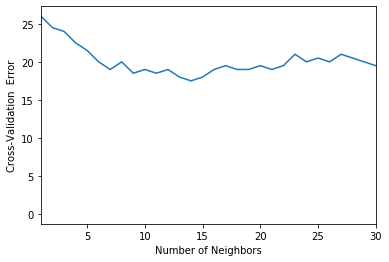

In [13]:
error=crossValidationkNN(traindata,trainlabels,30)
print(error)
print(len(error))
# print(n)
# indexx_all=np.array([np.arange(0,int(N))])
# n=1
# N=200
# indexx=np.array(np.arange(int(n*N/5),int((n+1)*N/5)))
# print(indexx)
# indexx2=np.delete(indexx_all,np.s_[int(n*N/5):int((n+1)*N/5)] )
# # print(indexx2)
# # print(indexx_all)
# # print(indexx)
# T_data=traindata[indexx2,:] 
# T_lables=trainlabels[indexx2]
# print(T_data)
# print(T_lables)

pylab.plot(np.arange(0,31, dtype=float), error)
pylab.xlim(1, 30)

pylab.xlabel("Number of Neighbors")
pylab.ylabel("Cross-Validation  Error")

Select the number of neighbors which minimizes the cross-validation error. What is the cross-validation error for this number of neighbors? <b>(10 points)</b>

In [14]:
# Put your code here
a=np.argmin(error[1:]) # since error[0] is meaningless
print(a+1)
print("Min. error ",error[14] )

Min. error 
14
Min. error  17.5


<b>k=14 minimizes the cross-validation error which is 17.5% 

Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. Is it higher or lower than the cross-validation error you found in the last part of the problem? **(10 points)**

In [19]:
# Put your code here
obj2=KNeighborsClassifier(n_neighbors=14)
obj2.fit(traindata, trainlabels)
pred_lables2=obj2.predict(testdata)
error=(zero_one_loss(testlabels,pred_lables2)*100)
print("Error on the test data",error)

Error on the test data 21.4


<b>The error on the test data was found to be 21.4% which is higher than the cross-validation error I had found previously.

### Problem 3: Detecting Cancer with SVMs and Logistic Regression (45 points)

We consider the [Breast Cancer Wisconsin Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) from 
W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993. 

The authors diagnosed people by characterizing 3 cell nuclei per person extracted from the breast (pictures [here](http://web.archive.org/web/19970225174429/http://www.cs.wisc.edu/~street/images/)), each with 10 features (for a 30-dimensional feature space):

1. radius (mean of distances from center to points on the perimeter) 

2. texture (standard deviation of gray-scale values) 

3. perimeter 

4. area 

5. smoothness (local variation in radius lengths) 

6. compactness (perimeter^2 / area - 1.0) 

7. concavity (severity of concave portions of the contour) 

8. concave points (number of concave portions of the contour) 

9. symmetry 

10. fractal dimension ("coastline approximation" - 1)

and classified the sample into one of two classes: Malignant ($+1$) or Benign ($-1$). You can read the original paper for more on what these features mean.

You will be attempting to classify if a sample is Malignant or Benign using Support Vector Machines, as well as Logistic Regression. Since we don't have all that much data, we will use 10-fold cross-validation to tune our parameters for our SVMs and Logistic Regression. We use 90% of the data for training, and 10% for testing.

You will be experimenting with SVMs using Gaussian RBF kernels through sklearn.svm.SVC, linear SVMs through sklearn.svm.LinearSVC, and sklearn.linear_model.LogisticRegression for Logistic Regression. 

Your model selection will be done with cross-validation via sklearn.model_selection's cross_val_score. This returns the accuracy for each fold, i.e. the fraction of samples classified correctly. Thus, the cross-validation error is simply 1-mean(cross_val_score).

First, we load the data. We will use scikit-learn's train test split function to split the data. The data is scaled for reasons outlined <a href="http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">here</a>. In short, it helps avoid some numerical issues and avoids some problems with certain features which are typically large affecting the SVM optimization problem unfairly compared to features which are typically small. 

In [20]:
from sklearn.model_selection import train_test_split

cancer = genfromtxt('Data/wdbc.csv', delimiter=',')

np.random.seed(seed=282017) # seed the RNG for repeatability
idx=np.random.permutation(cancer.shape[0])
cancer=cancer[idx]

cancer_features=cancer[:,1:]
cancer_labels=cancer[:,0]

#The training data is in data_train with labels label_train. 
# The test data is in data_test with labels label_test.
data_train, data_test, label_train, label_test = train_test_split(cancer_features,cancer_labels,test_size=0.1,random_state=292017)

# Rescale the training data and scale the test data correspondingly
scaler=MinMaxScaler(feature_range=(-1,1))
data_train=scaler.fit_transform(data_train) #Note that the scaling is determined solely via the training data!
data_test=scaler.transform(data_test)

The soft margin linear SVM is tuned based on a parameter $C$, which controls how much points can be violating the margin (this isn't the same $C$ as in the notes, though it serves the same function; see the [scikit-learn documentation](http://scikit-learn.org/stable/modules/svm.html#svc) for details). 

Use cross-validation to select a value of $C$ for a linear SVM (sklearn.svm.LinearSVC) by varying $C$ from $2^{-5},2^{-4},\ldots,2^{15}$. 

Which value of $C$ would you choose, and why? What is the corresponding cross-validation error? <b>(10 points)</b>

In [52]:
#Put your code here
from sklearn.model_selection import cross_val_score
nos=range(-5,16,1)
C_data=[2**i for i in nos]
errors_C=[]
for x in C_data:
    clf = LinearSVC(dual=False,C=x)
    scores = cross_val_score(clf, data_train, label_train, cv=10)
    errors_C.append((1-(scores.mean()))*100)
# print(errors_C)
min_pos=np.argmin(np.asarray(errors_C))
print("Minimum error is ",errors_C[min_pos])
print("Postion of the min. error in C vector",min_pos)
print("Value of C=",C_data[min_pos],"=","2^-3")

Minimum error is  2.714932126696823
Postion of the min. error in C vector 2
Value of C= 0.125 = 2^-3


<b>The value of C=2^-3 should be choosen since it gives the minimum error cross-validation error which is about 2.71%

You will now experiment with using kernels in an SVM, particularly the Gaussian RBF kernel (in sklearn.svm.SVC). The SVM has two parameters to tune in this case: $C$ (as before), and $\gamma$, which is a parameter in the RBF. 

Use cross-validation to select parameters $(C,\gamma)$ by searching varying $(C,\gamma)$ over $C=2^{-5},2^{-4},\ldots,2^{15}$ and $\gamma=2^{-15},\ldots,2^{3}$ [So, you will try about 400 parameter choices]. Out of these, which $(C,\gamma)$ parameters would you choose? What is the corresponding cross-validation error? 

This procedure is known as a *grid search*.We are using a fairly coarse grid for this problem, but one could use a finer grid once the rough range of good parameters is known (rather than starting with a fine grid, which would waste a lot of time). <b>(10 points)</b>

In [64]:
# Put your code here
g_nos=range(-15,3,1)
G_data=[2**i for i in g_nos]
error_CG=np.zeros((len(C_data),len(g_nos)))
for i in range(0,len(C_data)):
    for j in range(0,len(G_data)):
        clf2 = SVC(C=C_data[i],gamma=G_data[j])
        scores = cross_val_score(clf2, data_train, label_train, cv=10)
        error_CG[i,j]=(1-scores.mean())*100


In [76]:
ind = np.unravel_index(np.argmin(error_CG, axis=None), error_CG.shape)
print(ind)
print("The min error is",error_CG[ind])
print("The value of C for min error is",C_data[ind[0]])
print("The value of Gamma for min is",G_data[ind[1]])

(8, 12)
The min error is 1.9457013574660564
The value of C for min error is 8
The value of Gamma for min is 0.125


<b>We should choose C=8=2^3 and Gamma=0.125=2^-3 as parameters for our classfiers as these give the minimum error which is 1.945%

As stated in a footnote in the notes, Logistic Regression normally has a regularizer parameter to promote stability. Scikit-learn calls this parameter $C$ (which is like $\lambda^{-1}$ in the notes); see the [LibLinear](http://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf) documentation for the exact meaning of $C$. 

Use cross-validation to select a value of $C$ for logistic regression (sklearn.linear_model.LogisticRegression) by varying $C$ from $2^{-14},2^{-4},\ldots,2^{14}$. You may optionally make use of sklearn.model_selection.GridSearchCV, or write the search by hand (as before). 

Which value of $C$ would you choose? What is the corresponding cross-validation error? **(5 points)**

In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
nos_new=range(-14,14,1)
C_new=[2**i for i in nos_new]
lgr_error=[]
for x in C_new:
    lgr = LogisticRegression(max_iter=5000,solver='lbfgs',C=x)
    scores = cross_val_score(lgr, data_train, label_train, cv=10)     
    lgr_error.append((1-(scores.mean()))*100)    

In [165]:
minerr=np.argmin(np.asarray(lgr_error))
print("The minimum error is",min(lgr_error))
print("The C value for minimum error is",C_new[minerr])


The minimum error is 2.1342383107088914
The C value for minimum error is 1


<b>The value of C that should be choose is C=1 = 2^0  which has 2.1342% cross validation error

Based on the classifiers you selected thusfar for Linear SVM, SVM + Gaussian RBF and Logistic Regression, which classifier would you pick? Make sure to take into account error, the application and computational considerations. **(5 points)**

<b> Based on my observations on the cross-validation errors so far for the optimum C and Gamma values: <br>
    Linear SVM - 2.71493%  <br>
    SVM + Gaussian RBF- 1.9457% <br>
    Logistic Regression-2.13423 % <br>
I would choose the Logistic classifier since its cross-validation error is one of the lowest and computationally takes much less time compared to SVM + Gaussian RBF which needs to optimize two parameters first. The logistic regression classifier error is just ~0.2 percent higher than SVM + Gaussian RBF and has a much lower computational cost. Considering that the application is predicting malignancy we have the option of further testing (biopsy) if our predictions are inaccurate and so lower computational cost (which lowers the price of the test) is preferred.

Train the classifier selected above on the whole training set. Then, estimate the prediction error using the test set. What is your estimate of the prediction error? How does it compare to the cross-validation error?  <b>(10 points)</b>

In [166]:
lgr_new = LogisticRegression(max_iter=500,solver='lbfgs',C=1)
lgr_new.fit(data_train, label_train)
pred=lgr_new.predict(data_test)
error2=(zero_one_loss(label_test,pred)*100)
print(error2)

0.0


The prediction error using the whole test set was found to be zero. This is way lower than the cross-validation error.

Do you think the 0,1-loss is appropriate performance measure to report, in this case? If so, why? If not, how would you measure performance? **(5 points)**

I think 0,1-loss function is appropriate for this case as using a logistic classifier we have a binary decision to make (+1 and -1). So the 0,1-loss function is suitable for this case.

## And this concludes Lab 3! 